In [101]:
import torch
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

We simulate embedding an entity to the answer space directly. So the query is dependent on only one entity!

In [102]:
def plot_embeddings(embs):
    embs_temp = embs.clone().detach().tolist()

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim3d(-2, 2)
    ax.set_ylim3d(-2, 2)
    ax.set_zlim3d(-2, 2)
    ax.view_init(25, 10)

    # plot embeddings
    for emb in embs_temp:
        ax.quiver(0, 0, 0, emb[0], emb[1], emb[2], color='blue')

In [103]:
"""Simple MLP model with 2 layers, simulating GCN model"""
class MLP(nn.Module):
    def __init__(self, num_bands, num_hyp, batch_size, embed_dim=3):
        super().__init__()
        self.num_bands = num_bands
        self.num_hyp = num_hyp
        self.embs = torch.nn.parameter.Parameter(data=torch.randn((batch_size, embed_dim)))
        firstlayer = embed_dim * num_bands
        secondlayer = firstlayer * num_hyp
        self.layers = nn.Sequential(
            nn.Linear(embed_dim, firstlayer),
            nn.ReLU(),
            nn.Linear(firstlayer, secondlayer)
        )
        
    def forward(self, input):
        # in: (batch_size, embed_dim)
        # out: (batch_size, num_bands, num_hyp, embed_dim)
        x = self.layers(input)
        return x.reshape(input.size(0), self.num_bands, self.num_hyp, input.size(1))

In [104]:
"""
Function that shuffles indexes (duplicates allowed) where at least we know
the new index is NOT the original index!
"""
def shuffled_indices(max_index):
    out = []
    for idx in range(max_index):
        out.append(random.choice([x for x in range(max_index) if not x == idx]))
    return out

shuffled_indices(20)


[10, 2, 0, 4, 1, 14, 1, 3, 6, 6, 12, 5, 3, 14, 16, 1, 5, 19, 9, 12]

In [105]:
def plot_answerspace(embs, space, batch_id=0):

    present = 0
    example_id = 0
    also_present = []
    for band_id in range(4):
        if torch.all(torch.sum(embs[batch_id] * space[batch_id][band_id], dim=-1) > 0):
            present += 1
            example_id = band_id   

            # see which embeddings are also present
            also_present = []
            # embs:     (num_ents, embed_dim)
            # space:    (batch, num_bands, num_hyp, embed_dim)
            embs_1 = embs.reshape(embs.size(0), 1, embs.size(1))                          # (num_ents, 1, embed_dim)
            space_1 = space[batch_id][band_id].reshape(1, space.size(2), space.size(3))   # (1, num_hyp, embed_dim)
            dot_inds = (torch.sum(embs_1 * space_1, dim=-1) > 0)
            ent_inds = torch.all(dot_inds, dim=-1)
            for ent_id, ent_ind in enumerate(ent_inds):
                if ent_ind and (ent_id != batch_id):
                    also_present.append(embs[ent_id].clone().detach().tolist())

    print(f"Present in {present} bands, example of true (if present):")

    emb = embs[batch_id].clone().detach().tolist()
    hyps = space[batch_id][example_id].clone().detach().tolist()

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim3d(-2, 2)
    ax.set_ylim3d(-2, 2)
    ax.set_zlim3d(-2, 2)
    ax.view_init(25, 10)

    # plot target embedding
    ax.quiver(0, 0, 0, emb[0], emb[1], emb[2], color='green')

    # plot normal vectors
    for hyp in hyps:
        ax.quiver(0, 0, 0, hyp[0], hyp[1], hyp[2], color='blue')

    if also_present:
        for vec in also_present:
            ax.quiver(0, 0, 0, vec[0], vec[1], vec[2], color='red')

In [106]:
def predict(embs, space):
    answers = [[] for _ in range(embs.size(0))]

    space_1 = space.reshape(space.size(0), 1, space.size(1), space.size(2), space.size(3))          
    
    # add extra dimension for broadcasting:  
    # from  (num_ents_mode, embed_dim)
    # to    (1, num_ents_mode, 1, 1, embed_dim)
    embs_1 = embs.reshape(1, embs.size(0), 1, 1, embs.size(1))

    # calculate dot products of hyperplanes-embeddings
    # and convert positive/negative dot products to binary values
    # shape: (batch_size_mode, num_ents_mode, num_bands, num_hyp)
    dot_inds = torch.sum(space_1 * embs_1, dim=-1) > 0

    # only if all hyperplanes in a band are positive and the band contains the answer
    # shape: (batch_size_mode, num_ents_mode, num_bands)
    band_inds = torch.all(dot_inds, dim=-1)

    # if any band contains the entity, then the entity is a predicted answer
    # shape: (batch_size_mode, num_ents_mode)
    ent_inds = torch.any(band_inds, dim=-1)

    # iterate through all batches
    for batch_idx, batch in enumerate(ent_inds):
        # for all entities for that batch
        for ent_idx, ent_ind in enumerate(batch):
            # if the entity indicator is True (is in any band's answer space)
            if ent_ind:
                # we add the global entity index (=ID) to the answer list for that batch
                answers[batch_idx].append(ent_idx)
    return answers


In [107]:
def loss_function(hyp, pos_embeds, neg_embeds, pos_w=1, neg_w=1, div_w=1):
    # hyp shape:    (batch, num_bands, num_hyp, embed_dim)
    # embs shape:   (batch, embed_dim)
    # negs shape:   (batch, embed_dim)

    pos_ = pos_embeds.reshape(pos_embeds.size(0), 1, 1, pos_embeds.size(1))     # shape: (batch, 1, 1, embed_dim)
    pos_cos_sim = torch.cosine_similarity(pos_, hyp, dim=-1)                    # shape: (batch, num_bands, num_hyp)

    neg_ = neg_embeds.reshape(neg_embeds.size(0), 1, 1, neg_embeds.size(1))     # shape: (batch, 1, 1, embed_dim)
    neg_cos_sim = torch.cosine_similarity(neg_, hyp, dim=-1)                    # shape: (batch, num_bands, num_hyp)

    div_cos_sim = torch.cosine_similarity(hyp, hyp[:, :, shuffled_indices(hyp.size(2)), :], dim=-1) # shape: (batch, num_bands, num_hyp)

    # calculate band distance:
    band_pos_loss = -torch.mean(pos_cos_sim, dim=-1)    # shape (batch, num_bands)
    band_neg_loss =  torch.mean(neg_cos_sim, dim=-1)    # shape (batch, num_bands)
    band_div_loss =  torch.mean(div_cos_sim, dim=-1)    # shape (batch, num_bands)

    # aggregate band distances:
    pos_focus_w = torch.softmax(-band_pos_loss, dim=-1)
    batch_pos_loss = torch.sum(band_pos_loss * pos_focus_w, dim=-1)     # shape (batch)
    batch_neg_loss = torch.mean(band_neg_loss, dim=-1)                  # shape (batch)
    batch_div_loss = torch.sum(band_div_loss* pos_focus_w, dim=-1)      # shape (batch)

    # Calculate margin loss
    batch_loss = batch_pos_loss * pos_w + batch_neg_loss * neg_w + batch_div_loss * div_w

    loss = torch.mean(batch_loss, dim=-1) # shape (1)
    p = torch.mean(batch_pos_loss.detach(), dim=-1).item()
    n = torch.mean(batch_neg_loss.detach(), dim=-1).item()
    d = torch.mean(batch_div_loss.detach(), dim=-1).item()
    return loss, p, n, d

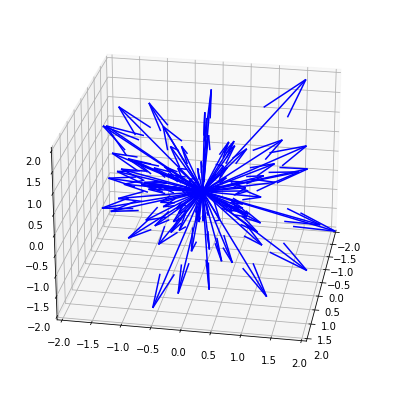

In [108]:
EMBED_DIM = 24
NUM_BANDS = 6
NUM_HYP = 16
BATCH_SIZE = 100

model = MLP(
    num_bands=NUM_BANDS,
    num_hyp=NUM_HYP,
    batch_size=BATCH_SIZE,
    embed_dim=EMBED_DIM
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# show initial random embeddings
plot_embeddings(model.embs)

100 | Loss: -0.069, pos_loss:-0.049, neg_loss:-0.006, div_loss:-0.029
200 | Loss: -0.106, pos_loss:-0.101, neg_loss:0.000, div_loss:-0.009
300 | Loss: -0.151, pos_loss:-0.151, neg_loss:-0.002, div_loss:0.005
400 | Loss: -0.184, pos_loss:-0.200, neg_loss:0.003, div_loss:0.027
500 | Loss: -0.233, pos_loss:-0.246, neg_loss:-0.008, div_loss:0.040
600 | Loss: -0.255, pos_loss:-0.289, neg_loss:0.000, div_loss:0.069
700 | Loss: -0.296, pos_loss:-0.330, neg_loss:-0.019, div_loss:0.108
800 | Loss: -0.322, pos_loss:-0.368, neg_loss:-0.014, div_loss:0.122
900 | Loss: -0.336, pos_loss:-0.403, neg_loss:-0.008, div_loss:0.150
1000 | Loss: -0.336, pos_loss:-0.434, neg_loss:0.010, div_loss:0.176
1100 | Loss: -0.359, pos_loss:-0.462, neg_loss:-0.006, div_loss:0.218
1200 | Loss: -0.362, pos_loss:-0.487, neg_loss:0.006, div_loss:0.237
1300 | Loss: -0.393, pos_loss:-0.509, neg_loss:-0.010, div_loss:0.253
1400 | Loss: -0.405, pos_loss:-0.530, neg_loss:-0.017, div_loss:0.282
1500 | Loss: -0.397, pos_loss:-0

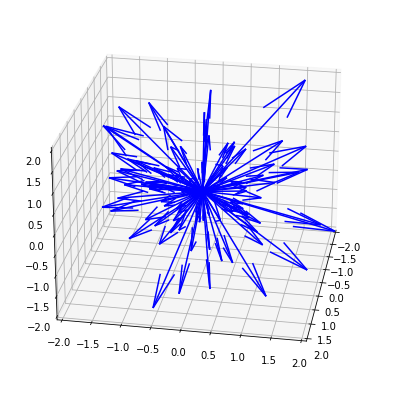

In [109]:
# training loop
for step in range(1500):

    # sample negative embeddings that is NOT equal to original index :-)
    neg_idx = shuffled_indices(model.embs.size(0))
    negs = model.embs[neg_idx, :]

    optimizer.zero_grad()
    hyps = model(model.embs)
    loss, p, n, d = loss_function(hyps, model.embs, negs, pos_w=1, neg_w=1, div_w=0.5)
    loss.backward()
    optimizer.step()

    if (step + 1) % 100 == 0:
        print(f"{step+1} | Loss: {loss.detach().item():.3f}, pos_loss:{p:.3f}, neg_loss:{n:.3f}, div_loss:{d:.3f}")

# plot all embs
plot_embeddings(model.embs)

In [110]:
pred = predict(model.embs, hyps)
for true_idx, b in enumerate(pred):
    print(f"Contains answer: {(true_idx in b)}, len: {len(b)}")

Contains answer: True, len: 8
Contains answer: True, len: 7
Contains answer: True, len: 11
Contains answer: True, len: 14
Contains answer: True, len: 11
Contains answer: True, len: 5
Contains answer: True, len: 5
Contains answer: True, len: 9
Contains answer: True, len: 7
Contains answer: True, len: 13
Contains answer: True, len: 7
Contains answer: True, len: 5
Contains answer: True, len: 5
Contains answer: True, len: 3
Contains answer: True, len: 10
Contains answer: True, len: 9
Contains answer: True, len: 7
Contains answer: True, len: 8
Contains answer: True, len: 8
Contains answer: True, len: 11
Contains answer: True, len: 9
Contains answer: True, len: 4
Contains answer: True, len: 6
Contains answer: True, len: 9
Contains answer: True, len: 14
Contains answer: True, len: 8
Contains answer: True, len: 10
Contains answer: True, len: 12
Contains answer: True, len: 10
Contains answer: True, len: 3
Contains answer: True, len: 2
Contains answer: True, len: 5
Contains answer: True, len: 8


53
Present in 4 bands, example of true (if present):


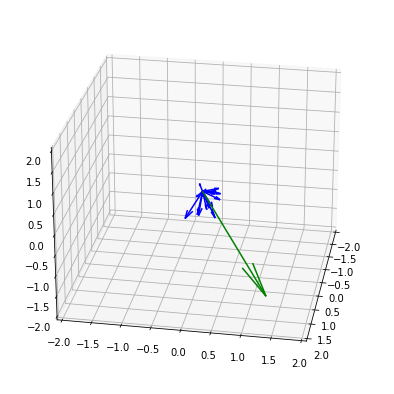

In [111]:
# plot one example with hyperplanes
id1 = random.randint(0, BATCH_SIZE-1)
print(id1)
plot_answerspace(model.embs, hyps, batch_id=id1)    